In [11]:
from pathlib import Path
import os
import pickle
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/mattw/Dropbox/github/int-brain-lab/analysis')
from v1_protocol.rf_mapping import compute_rfs
from v1_protocol.rf_mapping import find_peak_responses
from v1_protocol.rf_mapping import interpolate_rfs
from v1_protocol.rf_mapping import find_contiguous_pixels
from v1_protocol.rf_mapping import plot_rf_distributions

In [ ]:
sns.set_style('white')
sns.set_context('talk')

### 0. load data

In [8]:
# from oneibl.one import ONE
# import alf.io as ioalf

# # get the data from flatiron and the current folder
# one = ONE()
# eid = one.search(subject='ZM_1887', date='2019-07-19', number=1)
# D = one.load(eid[0], clobber=False, download_only=True)
# session_path = Path(D.local_path[0]).parent
# # load objects
# spikes = ioalf.load_object(session_path, 'spikes')
# clusters = ioalf.load_object(session_path, 'clusters')
# channels = ioalf.load_object(session_path, 'channels')
# trials = ioalf.load_object(session_path, '_ibl_trials')

# get data stored locally
# data_dir = '/home/mattw/data/ibl/ZM_1887-2019-07-10-001-probe-right'
# spikes = np.load(glob.glob(os.path.join(data_dir, '*spikes.times*'))[0])
# clusters = np.load(glob.glob(os.path.join(data_dir, '*spikes.clusters*'))[0])
# sync_ch = np.load(glob.glob(os.path.join(data_dir, '*sync.channels*'))[0])
# sync_pol = np.load(glob.glob(os.path.join(data_dir, '*sync.polarities*'))[0])
# sync_times = np.load(glob.glob(os.path.join(data_dir, '*sync.times*'))[0])

# get already processed data stored locally
data_dir = '/home/mattw/data/ibl/ZM_1887-2019-07-10-001-probe-right'
spike_times = np.load(os.path.join(data_dir, 'extracted_npy', 'spikes.times.npy'))
spike_clusters = np.load(os.path.join(data_dir, 'extracted_npy', 'spikes.clusters.npy'))
stim_metadata_file = os.path.join(data_dir, 'extracted_npy', 'stim.metadata.pkl')
with open(stim_metadata_file, 'rb') as f:
    stim_metadata = pickle.load(f)
    
rf_mapping_stim = stim_metadata['stim_metadata'][2]
rf_mapping_stim_times = np.squeeze(stim_metadata['stim_times'][2])

### 1. compute on/off receptive fields

In [7]:
# method in Durand et al 2016
rfs = compute_rfs(
    spike_times, spike_clusters, rf_mapping_stim_times, rf_mapping_stim, 
    lags=8, binsize=0.025)

# reverse correlation method
# rfs = compute_rfs_corr(
#     spike_times, spike_clusters, rf_mapping_stim_times, rf_mapping_stim, 
#     lags=4, binsize=0.05)

### 2. compute receptive field areas

In [9]:
# quotes from Durand et al 2016

# "the larger of the ON and OFF peak responses was taken to be the maximum
# firing rate of the cell"
peaks = find_peak_responses(rfs)

# "the trial-averaged mean firing rates within the peak bins were then used
# to estimate the sizes of the ON and OFF subfields...we interpolated each
# subfield using a 2D bilinear interpolation."
peaks_interp = interpolate_rfs(peaks, bin_scale=0.5)

# "All pixels in the interpolated grids that were <35% of the cell's
# maximum firing rate were set to zero and a contiguous non-zero set of
# pixels, including the peak pixel, were isolated"
rf_areas = find_contiguous_pixels(peaks_interp, threshold=0.35)

### 3. plot results

#### display single receptive field

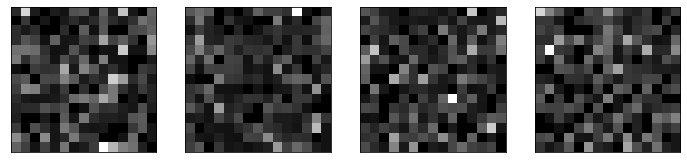

In [12]:
n_rows = 1
n_cols = 4
i = 22
sub = 'on'
plt.figure(figsize=(3 * n_cols, 3 * n_rows))
for j in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, j+1)
    rf = rfs[sub][i][:, :, j]
    plt.imshow(rf, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

#### display peak responses for multiple cells

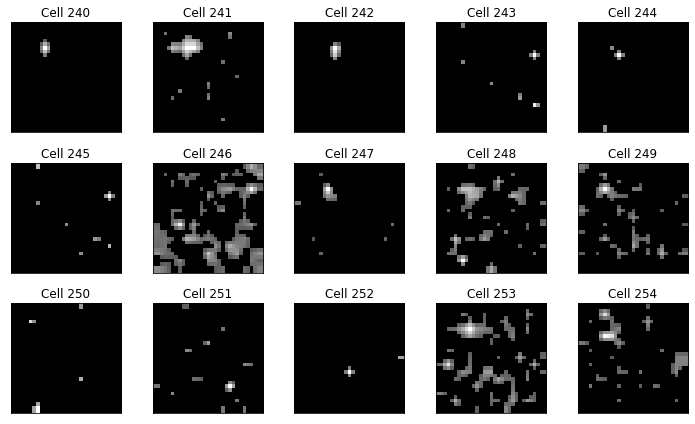

In [15]:
i = 240  # starting cell id
sub = 'off'  # 'on' | 'off'

n_rows = 3
n_cols = 5
plt.figure(figsize=(2 * n_cols, 2 * n_rows))
for j in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, j+1)
    rf = np.copy(peaks_interp[sub][i+j])
    max_rf = np.max([
        np.max(peaks_interp['on'][i+j]),
        np.max(peaks_interp['off'][i+j])])
    rf[rf < max_rf * 0.35] = 0
    plt.imshow(rf, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Cell %i' % (i+j))
plt.tight_layout()
plt.show()

#### plot receptive field size distributions

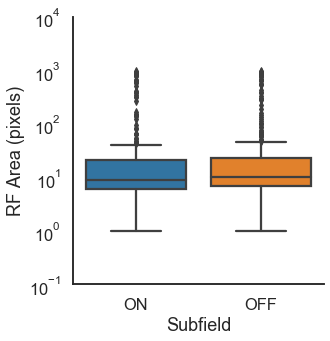

In [21]:
splt = plot_rf_distributions(rf_areas, plot_type='box')

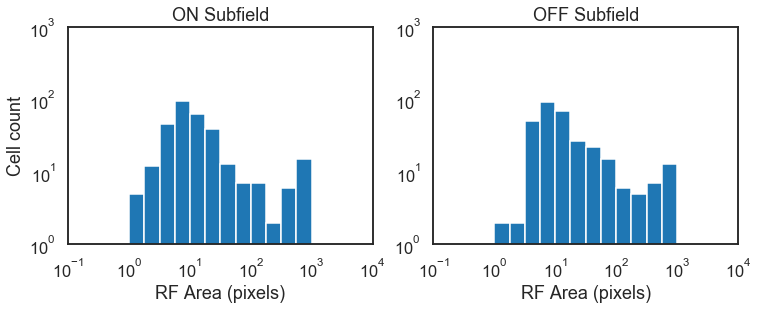

In [22]:
fig = plot_rf_distributions(rf_areas, plot_type='hist')